Import packages

In [1]:
import sys
import os
import sklearn
import pprint # to neatly print dictionary results
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing # convenient dataset for continuous regression
from sklearn.metrics import r2_score, median_absolute_error

Import custom package

In [2]:
sys.path.insert(0, os.path.abspath('..'))  # hacky way to import within package
from AutoML import AutomatedRegression

/export/home/owen/anaconda3/envs/env_AutoML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prepare dataset

In [3]:
dataset = fetch_california_housing()
X_full, y_full = dataset.data, dataset.target
y = pd.DataFrame(y_full, columns = dataset.target_names)
X = pd.DataFrame(X_full, columns = dataset.feature_names)

# Contents
- ### 1: minimal run 
    - Basic automated regresion using linear models
- ### 2: non-linearizing linear regressors
    - Adding non-linear transformations to data in `AutomatedRegression` prior to regression
- ### 3: additional weak predictors
    - Adding additional, but worse, models to the stacked regression
- ### 4: combining models
    - Training seperately linear models and boosted models, then combine to train stacked model
- ### 5: continue model training
    - Add trails to existing model

##  Regression #1: minimal run
Select two linear regressors and optimize them towards maximizing the $R^2$ score on the training fraction (1 - `test_frac`). Regression is assessed on the test fraction of data using metrics `r2_score` and `median_absolute_error`.   

In [4]:
result1 = AutomatedRegression(
    y = y,
    X = X,
    test_frac = 0.2,
    n_trial = 10,
    write_folder = 'test1',
    metric_optimise = r2_score,
    metric_assess = [r2_score, median_absolute_error],
    optimisation_direction = 'maximize',
    models_to_optimize = ['bayesianridge', 'lassolars',],
    models_to_assess = ['bayesianridge', 'lassolars'],
    )

In [5]:
result1.apply()

[I 2023-03-17 14:47:12,691] A new study created in RDB with name: regression_bayesianridge
[I 2023-03-17 14:47:12,831] Trial 0 finished with value: 0.6114649964157707 and parameters: {'scaler': 'minmax', 'transformers': None, 'n_iter': 32, 'tol': 86.61761457883176, 'alpha_1': 0.010260065124896791, 'alpha_2': 0.12042752972516801, 'lambda_1': 1.6063676259174453e-08, 'lambda_2': 50.01479828856935}. Best is trial 0 with value: 0.6114649964157707.
[I 2023-03-17 14:47:13,645] Trial 1 finished with value: 0.572269074512378 and parameters: {'scaler': None, 'transformers': 'quantile_trans', 'n_quantiles': 1800, 'n_iter': 123, 'tol': 61.18528947611942, 'alpha_1': 2.4827821051950883e-07, 'alpha_2': 8.345387083873532e-06, 'lambda_1': 4.609124432595992e-05, 'lambda_2': 0.0003636636071695854}. Best is trial 0 with value: 0.6114649964157707.
[I 2023-03-17 14:47:14,205] Trial 2 finished with value: 0.5722553016703621 and parameters: {'scaler': None, 'transformers': 'quantile_trans', 'n_quantiles': 700

{'bayesianridge_best': [[0.5746486847782558, 0.04491854111867268],
                        [0.41187120157711216, 0.01760995245027687]],
 'lassolars_best': [[0.5836617695331447, 0.019466865289664136],
                    [0.41681839445319485, 0.012251609884791978]],
 'stacked': [[0.5750570170344448, 0.04419138492915843],
             [0.41144112933621224, 0.017016800352465267]]}


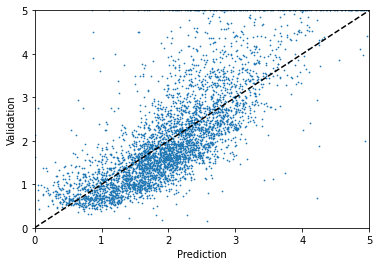

In [6]:
pprint.pprint(result1.summary)
plt.scatter(result1.y_pred, result1.y_test, s = 0.5); plt.plot([0,5], [0,5], '--k'); 
plt.xlim([0,5]); plt.ylim([0,5]); plt.xlabel("Prediction"); _ = plt.ylabel("Validation") 

The first row contains the first assessment metric, `r2_score`, with the second being `median_absolute_error`. The second column contains the standard deviation on 5-fold cross validation of the test fraction. Cross validation can be tweaked to preference by supplying a different `cross_validation` input to the `AutomatedRegression` class.

The `bayesianridge` regressor performs worse than `lassolars` on the $R^{2}$ metric but better on the MAE. The stacked regressor is slightly between the two.

##  Regression #2: non-linearizing linear regressors
We add a spline transformation to the previous regression. This adds non-linearity to the `X`-matrix which can improve performance of linear models on non-linear data. 

However, the addition of a spline transformation can penalize performance if its unsuitable for the data or model. Since this is not desireable, the optimization tests the performance both with and without spline transformations. Therefore, even if the inclusion of a spline is specified through `spline_value`, optimisation might return an optimized model without any spline transformations.

In addition to splines, two further transformations are supplied, namely: `poly_value` and `pca_value`. The former performs a polynomial expansion on the `X`-matrix, which can be benifitical if, for instance, the product of `X[param1]` and `X[param2]` contains more information than the individual parameters. Furthermore, the added degrees of freedom tend to be beneficial to linear models. However, polynomial expansions yield an exponential growth in parameters which can significantly increase training time (and memory requirements). If a lot of redundant information is supplied, consider applying a PCA compression on the `X`-matrix using `pca_value`. This can significantly reduce parameters with low variance, though, if these parameters are nonetheless important for regression, this will negatively affect performance.

If all are provided, the transformations are applied in the order: 
<br>
$\qquad$ X --> polynomial expansion -- > spline transformation --> (`X`-scaler) --> PCA compression --> regression --> $\hat{\textit{y}}$
<br>
The `X`-scaler is automatically included (even when no other transformations are specified). It performs standard transformations on the `X`-matrix such as MinMax, Standard, Robust (all from the sklearn library) or no scaling. Splines, polynomial expansions, `X`-scalers and pca compression are all applied seperately on the training and testing dataset to avoid data leakage

In [7]:
result2 = AutomatedRegression(
    y=y,
    X=X,
    test_frac = 0.2,
    n_trial=10,
    write_folder='test2',
    metric_optimise=r2_score,
    metric_assess=[r2_score, median_absolute_error],
    optimisation_direction='maximize',
    models_to_optimize=['bayesianridge', 'lassolars',],
    models_to_assess=['bayesianridge', 'lassolars'],
    spline_value={'n_knots': 10, 'degree':3},
    # poly_value={'degree': 2, 'interaction_only'= True},
    # pca_value={'n_components': 0.95},
    )

In [8]:
result2.apply()

[I 2023-03-17 14:47:22,657] A new study created in RDB with name: regression_bayesianridge
[I 2023-03-17 14:47:22,815] Trial 0 finished with value: 0.5722055796461042 and parameters: {'scaler': 'minmax', 'feature_combo': False, 'transformers': 'quantile_trans', 'n_quantiles': 2500, 'n_iter': 286, 'tol': 2.0584494393744, 'alpha_1': 50.01479828856935, 'alpha_2': 2.1106995036049625, 'lambda_1': 1.3285903900544182e-06, 'lambda_2': 6.580360277501306e-07}. Best is trial 0 with value: 0.5722055796461042.
[I 2023-03-17 14:47:24,911] Trial 1 finished with value: 0.6948275330435363 and parameters: {'scaler': 'standard', 'feature_combo': True, 'spline_value': {'degree': 3, 'extrapolation': 'constant', 'include_bias': True, 'knots': 'uniform', 'n_knots': 10, 'order': 'C'}, 'transformers': 'quantile_trans', 'n_quantiles': 1500, 'n_iter': 188, 'tol': 78.5175961414496, 'alpha_1': 9.925166969962287e-07, 'alpha_2': 0.0013878559259972313, 'lambda_1': 0.008397416393796027, 'lambda_2': 2.9140978279786215e

{'bayesianridge_best': [[0.6711806127338782, 0.014000492787596512],
                        [0.30072114586586635, 0.004122525624071498]],
 'lassolars_best': [[0.658265869375476, 0.005695592287020407],
                    [0.3544836428690491, 0.012629354363624154]],
 'stacked': [[0.6882784255288551, 0.01652177430910997],
             [0.3310255388188949, 0.010358731489040058]]}


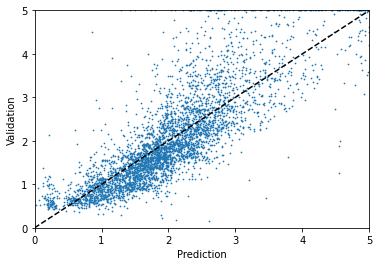

In [9]:
pprint.pprint(result2.summary)
plt.scatter(result2.y_pred, result2.y_test, s = 0.5); plt.plot([0,5], [0,5], '--k'); 
plt.xlim([0,5]); plt.ylim([0,5]); plt.xlabel("Prediction"); _ = plt.ylabel("Validation") 

Indeed performance of linear methods `bayesianridge` and `lassolars`improves significantly after the spline transformation

##  Regression #3: additional weak predictors
The final regression is performed by applying a `Ridge` regressor on the output of the previous regressors, i.e. stacking. The idea being that the final regressor learns from the combination of original results, thereby allowing it to make a new and improved prediction. To increase diversity for the final stacking operation, additional weak predictors can be added. These are versions of the same regressor but for whom the performance was less than the best performing model.

In [10]:
result3 = AutomatedRegression(
    y=y,
    X=X,
    test_frac = 0.2,
    n_trial=10,
    write_folder='test3',
    metric_optimise = r2_score,
    metric_assess = [r2_score, median_absolute_error],
    optimisation_direction = 'maximize',
    models_to_optimize=['bayesianridge', 'lassolars'],
    models_to_assess=['bayesianridge', 'lassolars'],
    spline_value={'n_knots': 10, 'degree':3},
    n_weak_models=3
    )

In [11]:
result3.apply()

[I 2023-03-17 14:47:40,975] A new study created in RDB with name: regression_bayesianridge
[I 2023-03-17 14:47:41,184] Trial 0 finished with value: 0.5722055796461042 and parameters: {'scaler': 'minmax', 'feature_combo': False, 'transformers': 'quantile_trans', 'n_quantiles': 2500, 'n_iter': 286, 'tol': 2.0584494393744, 'alpha_1': 50.01479828856935, 'alpha_2': 2.1106995036049625, 'lambda_1': 1.3285903900544182e-06, 'lambda_2': 6.580360277501306e-07}. Best is trial 0 with value: 0.5722055796461042.
[I 2023-03-17 14:47:43,764] Trial 1 finished with value: 0.6948275330435363 and parameters: {'scaler': 'standard', 'feature_combo': True, 'spline_value': {'degree': 3, 'extrapolation': 'constant', 'include_bias': True, 'knots': 'uniform', 'n_knots': 10, 'order': 'C'}, 'transformers': 'quantile_trans', 'n_quantiles': 1500, 'n_iter': 188, 'tol': 78.5175961414496, 'alpha_1': 9.925166969962287e-07, 'alpha_2': 0.0013878559259972313, 'lambda_1': 0.008397416393796027, 'lambda_2': 2.9140978279786215e

Number of unique weak models less than requested number of weak models: 2 < 3 
n_weak_models set to total number of weak models instead.


{'bayesianridge_0': [[0.5498057170994974, 0.016331220445353335],
                     [0.3640467914681688, 0.007053629472459124]],
 'bayesianridge_8': [[0.624118932622044, 0.10315427666153491],
                     [0.3367081830998763, 0.009595816163840405]],
 'bayesianridge_9': [[0.5496871559020452, 0.01646292818008975],
                     [0.3643142556083123, 0.0070843413411906895]],
 'bayesianridge_best': [[0.6711806127338782, 0.014000492787596512],
                        [0.30072114586586635, 0.004122525624071498]],
 'lassolars_1': [[0.45473063332058655, 0.010815709658664633],
                 [0.41345719910704604, 0.008375519446263864]],
 'lassolars_2': [[0.6520470840879476, 0.008504347903558543],
                 [0.36392414058983014, 0.019064634590307626]],
 'lassolars_best': [[0.658265869375476, 0.005695592287020407],
                    [0.3544836428690491, 0.012629354363624154]],
 'stacked': [[0.692563941820388, 0.016095537944264195],
             [0.3280133969006819, 0.00

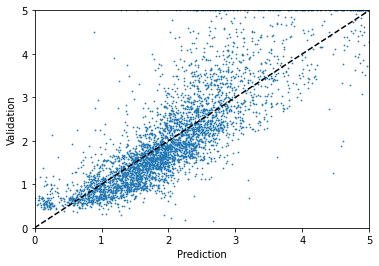

In [12]:
pprint.pprint(result3.summary)
plt.scatter(result3.y_pred, result3.y_test, s = 0.5); plt.plot([0,5], [0,5], '--k'); 
plt.xlim([0,5]); plt.ylim([0,5]); plt.xlabel("Prediction"); _ = plt.ylabel("Validation") 

The `stacked` regressor indeed slightly improves over the previous result despite including several worse performing models. 

##  Regression #4: combining models
Linear regressors are nice because they train fast and run efficiently but depending on the regression objective, diffferent regression models might outperform a linear model. Here we combine both linear and boosted models

First we set up a class instance containing two linear methods with optional spline transformations. We apply the hyperoptimisation. Next we create a new class instance with boosted methods which we write to the same folder as the previous linear models. Since linear methods generally train faster, less trials are allocated to them with more trials to the boosted methods. In the second class instance we assess the performance for all four models (as they are saved to the same directory) with an additional five weak predictors to make our final estimate.

In [13]:
result4_1 = AutomatedRegression(
    y=y,
    X=X,
    test_frac = 0.2,
    n_trial=15,
    write_folder='test4',
    metric_optimise = r2_score,
    metric_assess = [r2_score, median_absolute_error],
    optimisation_direction = 'maximize',
    models_to_optimize=['bayesianridge', 'lassolars',],
    models_to_assess=[ 'lassolars', 'bayesianridge'],
    spline_value={'n_knots': 10, 'degree':3},
    
    )


result4_2 = AutomatedRegression(
    y=y,
    X=X,
    test_frac = 0.2,
    n_trial=30,
    write_folder='test4',
    metric_optimise = r2_score,
    metric_assess = [r2_score, median_absolute_error],
    optimisation_direction = 'maximize',
    models_to_optimize=['lightgbm', 'catboost',],
    models_to_assess=['lassolars', 'bayesianridge', 'lightgbm', 'catboost',],
    n_weak_models=5
    )

In [14]:
result4_1.regression_hyperoptimise()
result4_2.apply()

[I 2023-03-17 14:48:04,187] A new study created in RDB with name: regression_bayesianridge
[I 2023-03-17 14:48:04,348] Trial 0 finished with value: 0.5722055796461042 and parameters: {'scaler': 'minmax', 'feature_combo': False, 'transformers': 'quantile_trans', 'n_quantiles': 2500, 'n_iter': 286, 'tol': 2.0584494393744, 'alpha_1': 50.01479828856935, 'alpha_2': 2.1106995036049625, 'lambda_1': 1.3285903900544182e-06, 'lambda_2': 6.580360277501306e-07}. Best is trial 0 with value: 0.5722055796461042.
[I 2023-03-17 14:48:06,312] Trial 1 finished with value: 0.6948275330435363 and parameters: {'scaler': 'standard', 'feature_combo': True, 'spline_value': {'degree': 3, 'extrapolation': 'constant', 'include_bias': True, 'knots': 'uniform', 'n_knots': 10, 'order': 'C'}, 'transformers': 'quantile_trans', 'n_quantiles': 1500, 'n_iter': 188, 'tol': 78.5175961414496, 'alpha_1': 9.925166969962287e-07, 'alpha_2': 0.0013878559259972313, 'lambda_1': 0.008397416393796027, 'lambda_2': 2.9140978279786215e

[I 2023-03-17 14:48:26,301] Trial 8 pruned. 
[I 2023-03-17 14:48:26,502] Trial 9 pruned. 
[I 2023-03-17 14:48:26,616] Trial 10 pruned. 
[I 2023-03-17 14:48:27,167] Trial 11 pruned. 
[I 2023-03-17 14:48:27,303] Trial 12 pruned. 
[I 2023-03-17 14:48:27,425] Trial 13 pruned. 
[I 2023-03-17 14:48:27,726] Trial 14 finished with value: 0.6096592632442869 and parameters: {'scaler': 'standard', 'feature_combo': False, 'transformers': None, 'alpha': 0.007207021418439127, 'normalize': False, 'random_state': 42}. Best is trial 2 with value: 0.6835229506799709.
[I 2023-03-17 14:48:27,823] A new study created in RDB with name: regression_lightgbm
[I 2023-03-17 14:48:28,182] Trial 0 finished with value: 0.7916801237418456 and parameters: {'scaler': 'minmax', 'transformers': None, 'objective': 'regression', 'max_depth': 4, 'n_estimators': 1219, 'max_bin': 511, 'min_gain_to_split': 3.185086660174142, 'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07, 'num_leaves': 79, 'feature_fr

[I 2023-03-17 14:48:51,071] Trial 21 pruned. 
[I 2023-03-17 14:48:51,396] Trial 22 pruned. 
[I 2023-03-17 14:48:51,712] Trial 23 pruned. 
[I 2023-03-17 14:48:52,043] Trial 24 pruned. 
[I 2023-03-17 14:48:52,626] Trial 25 pruned. 
[I 2023-03-17 14:48:54,267] Trial 26 finished with value: 0.8284919647074844 and parameters: {'scaler': 'minmax', 'transformers': None, 'objective': 'regression', 'max_depth': 19, 'n_estimators': 251, 'max_bin': 255, 'min_gain_to_split': 1.1900949262450307, 'lambda_l1': 4.621675810052402e-06, 'lambda_l2': 0.0012690364890019451, 'num_leaves': 110, 'feature_fraction': 0.6429074978021454, 'bagging_fraction': 0.7568398813548107, 'bagging_freq': 4, 'min_child_samples': 61, 'random_state': 42, 'verbosity': -1}. Best is trial 26 with value: 0.8284919647074844.
[I 2023-03-17 14:48:54,602] Trial 27 pruned. 
[I 2023-03-17 14:48:55,603] Trial 28 finished with value: 0.7871928531184889 and parameters: {'scaler': None, 'transformers': None, 'objective': 'regression', 'max_

[I 2023-03-17 14:51:45,177] Trial 25 finished with value: 0.8349687901610107 and parameters: {'scaler': None, 'transformers': None, 'depth': 7, 'iterations': 266, 'learning_rate': 0.23730351162047097, 'l2_leaf_reg': 0.6808453161477043, 'rsm': 0.26998248625362736, 'logging_level': 'Silent', 'random_seed': 42}. Best is trial 12 with value: 0.8452068673140614.
[I 2023-03-17 14:51:52,554] Trial 26 finished with value: 0.8370845929274504 and parameters: {'scaler': 'standard', 'transformers': None, 'depth': 8, 'iterations': 148, 'learning_rate': 0.25798734484089275, 'l2_leaf_reg': 0.3457948134359801, 'rsm': 0.9998152582126308, 'logging_level': 'Silent', 'random_seed': 42}. Best is trial 12 with value: 0.8452068673140614.
[I 2023-03-17 14:51:52,893] Trial 27 pruned. 
[I 2023-03-17 14:51:58,814] Trial 28 finished with value: 0.8342131283764779 and parameters: {'scaler': 'robust', 'transformers': None, 'depth': 7, 'iterations': 246, 'learning_rate': 0.2997776427540369, 'l2_leaf_reg': 0.95908606

{'bayesianridge_0': [[0.5498057170994974, 0.016331220445353335],
                     [0.3640467914681688, 0.007053629472459124]],
 'bayesianridge_1': [[0.6711806127338782, 0.014000492787596512],
                     [0.30072114586586635, 0.004122525624071498]],
 'bayesianridge_13': [[0.5496495897131192, 0.01652769588426782],
                      [0.36408140686172513, 0.007342997716909092]],
 'bayesianridge_4': [[0.5496322029140586, 0.016511122352860595],
                     [0.364135101769619, 0.007113158964180092]],
 'bayesianridge_8': [[0.624118932622044, 0.10315427666153491],
                     [0.3367081830998763, 0.009595816163840405]],
 'bayesianridge_best': [[0.6709617441056133, 0.013999512330875177],
                        [0.3007781740426764, 0.005285958784483169]],
 'catboost_0': [[0.8115732714171362, 0.016870474479930012],
                [0.2287556637588554, 0.008130629523281373]],
 'catboost_23': [[0.821627390787364, 0.025908505517102373],
                 [0.1851908

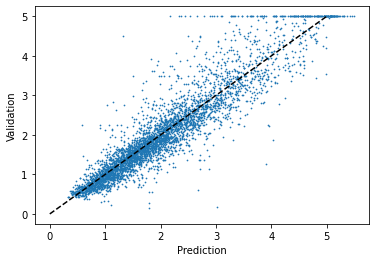

In [15]:
pprint.pprint(result4_2.summary)
plt.scatter(result4_2.y_pred, result4_2.y_test, s = 0.5); plt.plot([0,5], [0,5], '--k'); 
plt.xlabel("Prediction"); _ = plt.ylabel("Validation") 

Performance greatly increases when including the boosted models. Boosted models are generally more capable on non-linear datasets, even when supporting the latter by spline transformations. Linear models require more pre-processing in order to get their performance on the same level as the boosted methods. The enhanced diversity between models enables the `stacked` regression to outperform all other individual regressors.

## Regression #5: continue model training
Say we suspect the increased performance of the boosted models to be caused by training them for more trials than the linear models, then it would be desireable to perform an equal number of trials for all models. Here we reload the linear models and train them for an additional 15 trials up to a maximum of 30 trials total. In order to do so we specify the same write folder as during the previous optimisation. Since `lightgbm` and `catboost` already exist in this folder, they need not be not re-optimized in order to be assessed.

In [16]:
result5 = AutomatedRegression(
    y=y,
    X=X,
    test_frac = 0.2,
    n_trial=15,
    write_folder='test4',
    metric_optimise = r2_score,
    metric_assess = [r2_score, median_absolute_error],
    optimisation_direction = 'maximize',
    models_to_optimize=['bayesianridge', 'lassolars',],
    models_to_assess=[ 'lassolars', 'bayesianridge', 'lightgbm', 'catboost'],
    spline_value={'n_knots': 10, 'degree':3},
    reload_study=True,
    reload_trial_cap=30,
    n_weak_models=5,
    )

In [17]:
result5.apply()

[I 2023-03-17 14:52:45,249] Using an existing study with name 'regression_bayesianridge' instead of creating a new one.
[I 2023-03-17 14:52:47,842] Trial 15 finished with value: 0.6946833867676723 and parameters: {'scaler': 'robust', 'feature_combo': True, 'spline_value': {'degree': 3, 'extrapolation': 'constant', 'include_bias': True, 'knots': 'uniform', 'n_knots': 10, 'order': 'C'}, 'transformers': 'quantile_trans', 'n_quantiles': 100, 'n_iter': 34, 'tol': 71.54236611462439, 'alpha_1': 9.266050206840247e-05, 'alpha_2': 8.404829756234509e-05, 'lambda_1': 29.486197076717023, 'lambda_2': 6.252337803594864e-05}. Best is trial 12 with value: 0.695295000914793.
[I 2023-03-17 14:52:49,140] Trial 16 finished with value: 0.5723357906775528 and parameters: {'scaler': None, 'feature_combo': False, 'transformers': 'quantile_trans', 'n_quantiles': 2800, 'n_iter': 264, 'tol': 22.426930953813287, 'alpha_1': 0.13237080606341706, 'alpha_2': 2.3577126571566896e-06, 'lambda_1': 1.7947211532264313e-05, 

[I 2023-03-17 14:53:24,077] Trial 27 pruned. 
[I 2023-03-17 14:53:24,443] Trial 28 pruned. 
[I 2023-03-17 14:53:25,259] Trial 29 pruned. 
[I 2023-03-17 14:53:25,298] Using an existing study with name 'regression_lassolars' instead of creating a new one.
/export/home/owen/anaconda3/envs/xsar_xrft_il/lib/python3.9/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'degree': 3, 'extrapolation': 'constant', 'include_bias': True, 'knots': 'uniform', 'n_knots': 10, 'order': 'C'} which is of type dict.
  warnings.warn(message)
[I 2023-03-17 14:53:25,482] Using an existing study with name 'regression_bayesianridge' instead of creating a new one.
/export/home/owen/anaconda3/envs/xsar_xrft_il/lib/python3.9/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent

_________________________________________________________________
Stacked Regressor already exists in directory. Overwrite ? (y/n):
_________________________________________________________________
y
_____________________________
Stacked Regressor overwritten
_____________________________



{'bayesianridge_0': [[0.5498057170994974, 0.016331220445353335],
                     [0.3640467914681688, 0.007053629472459124]],
 'bayesianridge_10': [[0.6802290272985001, 0.022813299847545637],
                      [0.3382300435694019, 0.010522138367163711]],
 'bayesianridge_18': [[0.6803563031426613, 0.0227254231624716],
                      [0.3383187817003311, 0.010530447980471959]],
 'bayesianridge_27': [[0.6711983202929644, 0.013994889941151669],
                      [0.30078370436698887, 0.0041602513151555685]],
 'bayesianridge_3': [[0.5747173067925286, 0.04479967763015549],
                     [0.41160528906059357, 0.017452962466407845]],
 'bayesianridge_best': [[0.6710148947363228, 0.013960596496233704],
                        [0.30069697304575876, 0.005221923856980126]],
 'catboost_0': [[0.8115732714171362, 0.016870474479930012],
                [0.2287556637588554, 0.008130629523281373]],
 'catboost_23': [[0.821627390787364, 0.025908505517102373],
                 [0.

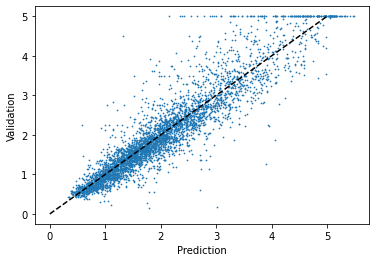

In [18]:
pprint.pprint(result5.summary)
plt.scatter(result5.y_pred, result5.y_test, s = 0.5); plt.plot([0,5], [0,5], '--k'); 
plt.xlabel("Prediction"); _ = plt.ylabel("Validation") 

As we had already trained a final stacked regressor in the `test4` directory, we are asked whether or not to overwrite the previous save of the stacked model with the new model.

Performance for the boosted models remains the same (as they are not trained) but for the linear models it changes ever so slightly. However, the additional 15 trials for the linear models have little effect, confirming that the additional training was not the root cause of improvement of the boosted methods over the linear methods.

Further improvements to the current predictions can be made by increasing the number of trials, including more regression methods and of course smart feature engineering or outlier removal prior to applying the regression. There are several unused hyperparamters of the `AutomatedRegression` class which may enhance performance, such as `boosted_early_stopping_rounds` for non-sklearn boosted methods (`lightgbm`, `catboost`, `xgboost`) and `nominal_columns` & `ordinal_columns` when categorical data is included